In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-dataset/Dataset_User_Agreement.pdf
/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json
/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json


In [2]:
# STEP 1: Import Required Libraries
import pandas as pd
import json
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
import warnings
warnings.filterwarnings('ignore')


In [3]:

# STEP 2: Convert JSON files to CSV (one by one)
# 1. Business file
business = pd.read_json('../input/yelp-dataset/yelp_academic_dataset_business.json', lines=True)
business.to_csv('yelp_business.csv', index=False)
print("Business file converted to CSV.")
# 2. Users file
user = pd.read_json('../input/yelp-dataset/yelp_academic_dataset_user.json', lines=True)
user.to_csv('yelp_user.csv', index=False)
print("User file converted to CSV.")
# 3. Checkin file
checkin = pd.read_json('../input/yelp-dataset/yelp_academic_dataset_checkin.json', lines=True)
checkin.to_csv('yelp_checkin.csv', index=False)
print("Checkin file converted to CSV.")
# 4. Tip file
tip = pd.read_json('../input/yelp-dataset/yelp_academic_dataset_tip.json', lines=True)
tip.to_csv('yelp_tip.csv', index=False)
print("Tip file converted to CSV.")
# 5. Review file (chunk conversion)
input_file = '../input/yelp-dataset/yelp_academic_dataset_review.json'
output_file = 'yelp_review.csv'
chunk_size = 100000
data_chunk = []
with open(input_file, 'r', encoding='utf8') as infile, open(output_file, 'w', newline='', encoding='utf8') as outfile:
    first_line = infile.readline()
    first_obj = json.loads(first_line)
    fieldnames = list(first_obj.keys())
    writer = csv.DictWriter(outfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerow(first_obj)

    for i, line in enumerate(tqdm(infile, desc="Converting Review JSON to CSV")):
        data_chunk.append(json.loads(line))
        if len(data_chunk) >= chunk_size:
            writer.writerows(data_chunk)
            data_chunk = []

    if data_chunk:
        writer.writerows(data_chunk)

print("Review file converted to CSV.")


Business file converted to CSV.
User file converted to CSV.
Checkin file converted to CSV.
Tip file converted to CSV.


Converting Review JSON to CSV: 6990279it [05:32, 21046.07it/s]


Review file converted to CSV.


In [4]:
# STEP 3: Data Cleaning and Merging
business = pd.read_csv('yelp_business.csv')
reviews = pd.read_csv('yelp_review.csv')

# حذف القيم المفقودة والمكررة
business.dropna(subset=['name', 'city'], inplace=True)
reviews.dropna(subset=['text', 'stars'], inplace=True)
business.drop_duplicates(subset=['business_id'], inplace=True)
reviews.drop_duplicates(subset=['review_id'], inplace=True)

# دمج الجداول
merged = pd.merge(reviews, business, on='business_id', how='left')

# أعمدة مهمة فقط
data = merged[['business_id', 'name', 'city', 'stars_x', 'text', 'categories']]
data.rename(columns={'stars_x': 'stars'}, inplace=True)

print("Data cleaned and merged successfully.")
print(data.head())


Data cleaned and merged successfully.
              business_id                          name          city  stars  \
0  XQfwVwDr-v0ZS3_CbbE5Xw  Turning Point of North Wales   North Wales    3.0   
1  7ATYjTIgM3jUlt4UM3IypQ    Body Cycle Spinning Studio  Philadelphia    5.0   
2  YjUWPpI6HXG530lwP-fb2A             Kettle Restaurant        Tucson    3.0   
3  kxX2SOes4o-D3ZQBkiMRfA                         Zaika  Philadelphia    5.0   
4  e4Vwtrqf-wpJfwesgvdgxQ                          Melt   New Orleans    4.0   

                                                text  \
0  If you decide to eat here, just be aware it is...   
1  I've taken a lot of spin classes over the year...   
2  Family diner. Had the buffet. Eclectic assortm...   
3  Wow!  Yummy, different,  delicious.   Our favo...   
4  Cute interior and owner (?) gave us tour of up...   

                                          categories  
0  Restaurants, Breakfast & Brunch, Food, Juice B...  
1  Active Life, Cycling Classes, T

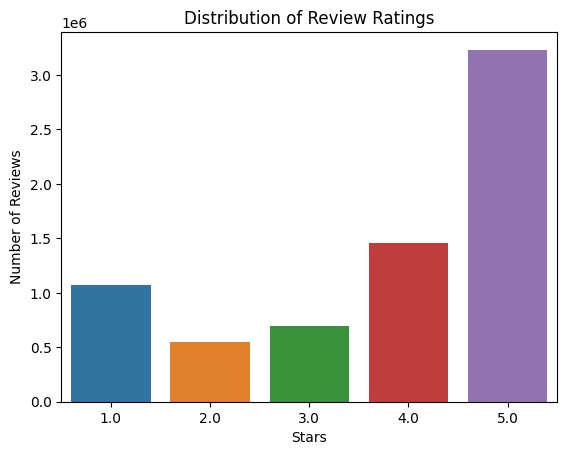

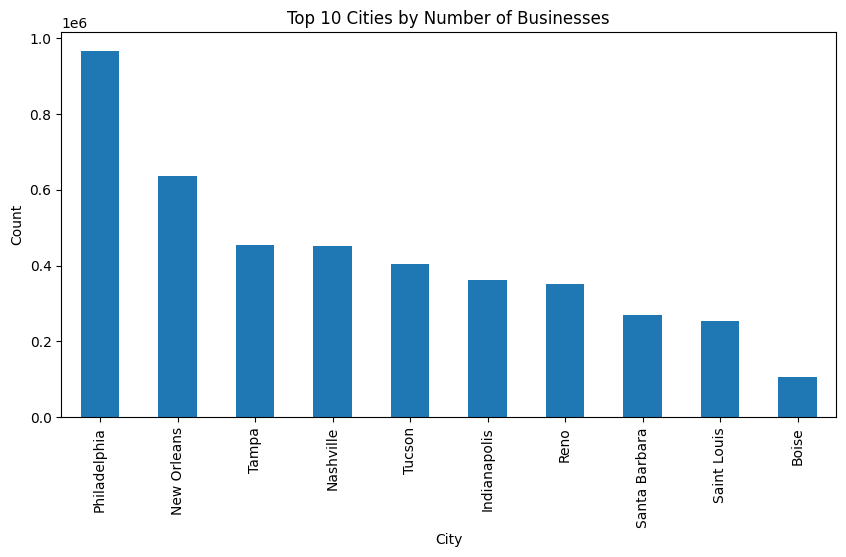

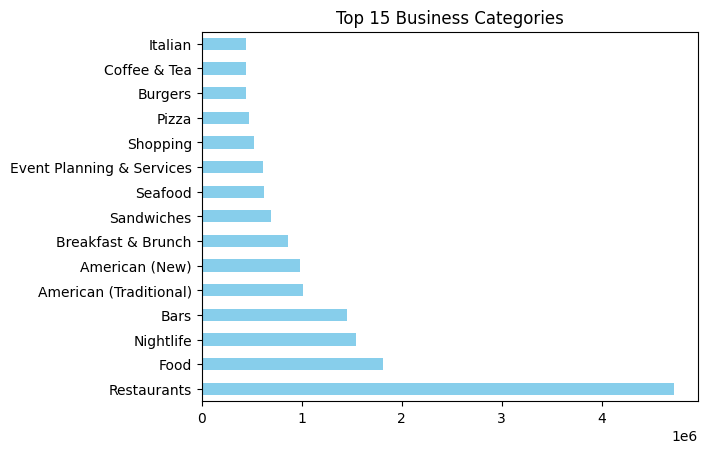

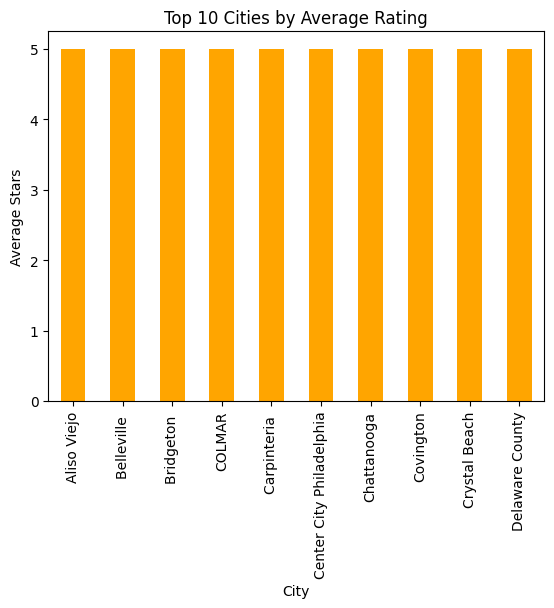

In [5]:
# STEP 4: Exploratory Data Analysis (EDA)

# توزيع التقييمات
sns.countplot(x='stars', data=data)
plt.title('Distribution of Review Ratings')
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')
plt.show()

# المدن الأكثر نشاطًا
top_cities = data['city'].value_counts().nlargest(10)
top_cities.plot(kind='bar', figsize=(10,5))
plt.title('Top 10 Cities by Number of Businesses')
plt.xlabel('City')
plt.ylabel('Count')
plt.show()

# أكثر الفئات شيوعًا
from collections import Counter
categories = data['categories'].dropna().str.split(', ')
cat_list = [cat for sublist in categories for cat in sublist]
pd.Series(Counter(cat_list)).nlargest(15).plot(kind='barh', color='skyblue')
plt.title('Top 15 Business Categories')
plt.show()

# متوسط التقييم حسب المدينة
city_rating = data.groupby('city')['stars'].mean().nlargest(10)
city_rating.plot(kind='bar', color='orange')
plt.title('Top 10 Cities by Average Rating')
plt.xlabel('City')
plt.ylabel('Average Stars')
plt.show()


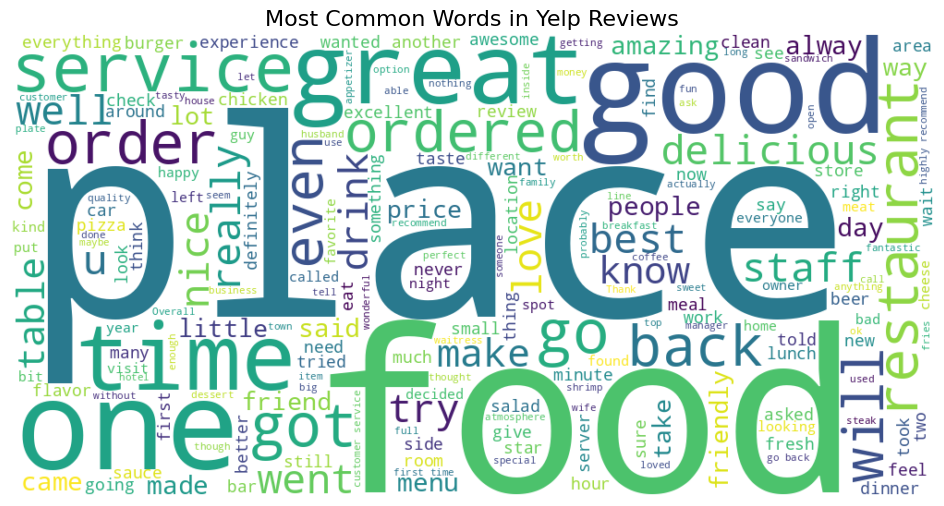

In [6]:
# STEP 5: Text Analysis (WordCloud)
sample_text = " ".join(text for text in data['text'].sample(20000, random_state=42))
wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(sample_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Yelp Reviews", fontsize=16)
plt.show()


In [7]:
# STEP 6: Export Cleaned Data for Power BI
data[['business_id', 'name', 'city', 'stars', 'categories']].to_csv('yelp_cleaned.csv', index=False)
print(" yelp_cleaned.csv is ready for Power BI visualization.")


 yelp_cleaned.csv is ready for Power BI visualization.
